
# Module 2: Optimized Fraud Detection Model Training

In [5]:
import os
# # print(os.getcwd())
os.chdir("..")

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix
from IPython.display import clear_output


from src.model_base import FraudDetectionModel, FocalLoss
from src.model_dataloaders import get_dataloaders
from scripts.model_training import model_evaluate

## Configuration

In [7]:
CONFIG = {
    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.0005,
    "weight_decay": 1e-5,
    "patience": 3  # For learning rate scheduling
}

## 1. Data Loading

In [8]:
try:
    train_loader, val_loader = get_dataloaders(CONFIG["batch_size"])
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
except FileNotFoundError:
    print("Error: Preprocessed data not found! Run Module 1 first.")
    print("Execute this cell after running preprocessing:")
    print("!python scripts/run_preprocess.py")

Training batches: 3
Validation batches: 1


## 2. Model Initialization

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = FraudDetectionModel().to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="max",
    patience=CONFIG["patience"],
)
criterion = FocalLoss()

## 3. Training Loop

In [10]:
# Training history storage
history = {
    "train_loss": [],
    "val_auc": [],
    "val_f1": []
}

# Interactive training loop
for epoch in range(CONFIG["epochs"]):
    # Training phase
    model.train()
    epoch_loss = 0
    
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Validation phase
    val_metrics = model_evaluate(model, val_loader, DEVICE)
    scheduler.step(val_metrics["auc_prc"])
    
    # Store metrics
    history["train_loss"].append(epoch_loss/len(train_loader))
    history["val_auc"].append(val_metrics["auc_prc"])
    history["val_f1"].append(val_metrics["f1"])
    
    # Live updating plot
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # Loss plot
    ax1.plot(history["train_loss"], label="Training Loss")
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    # Metrics plot
    ax2.plot(history["val_auc"], label="Validation AUPRC")
    ax2.plot(history["val_f1"], label="Validation F1")
    ax2.set_title("Validation Metrics")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Score")
    ax2.legend()
    
    plt.show()
    
    # Print metrics
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}")
    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val AUPRC: {history['val_auc'][-1]:.4f}")
    print(f"Val F1: {history['val_f1'][-1]:.4f}\n")

KeyboardInterrupt: 

## 4. Final Model Evaluation

/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/fed-fraud-detection/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'auc_prc': np.float64(0.9895502987863357), 'f1': 0.9625, 'y_true': [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64

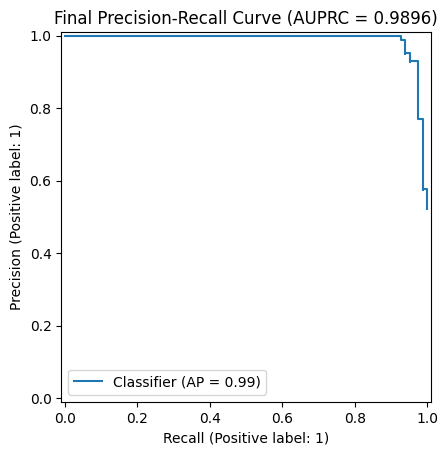

In [ ]:
# from typing import final
from sklearn.metrics import PrecisionRecallDisplay

# Generate precision-recall curve
final_metrics = model_evaluate(model, val_loader, DEVICE)
PrecisionRecallDisplay.from_predictions(
    final_metrics["y_true"],
    final_metrics["y_scores"]
)
plt.title(f"Final Precision-Recall Curve (AUPRC = {final_metrics['auc_prc']:.4f})")
plt.show()

## 5. Model Testing & Prediction

In [27]:
import torch.nn.functional as F

# Print 5 Sample Predictions
for i in range(5):
    model.eval()
    sample_idx = np.random.randint(len(val_loader.dataset))
    sample, label = val_loader.dataset[sample_idx]

    with torch.no_grad():
        prob = F.softmax(model(sample.unsqueeze(0).to(DEVICE)), dim=1)[0,1].item()

    print(f"Sample {sample_idx} Prediction:")
    print(f"- Actual: {'Fraud' if label else 'Legitimate'}")
    print(f"- Fraud Probability: {prob:.2%}")
    print(f"- Predicted: {'Fraud' if prob > 0.5 else 'Legitimate'}")
    print("-" * 40)

Sample 112 Prediction:
- Actual: Legitimate
- Fraud Probability: 35.07%
- Predicted: Legitimate
----------------------------------------
Sample 35 Prediction:
- Actual: Fraud
- Fraud Probability: 86.40%
- Predicted: Fraud
----------------------------------------
Sample 8 Prediction:
- Actual: Legitimate
- Fraud Probability: 30.12%
- Predicted: Legitimate
----------------------------------------
Sample 82 Prediction:
- Actual: Fraud
- Fraud Probability: 88.28%
- Predicted: Fraud
----------------------------------------
Sample 14 Prediction:
- Actual: Legitimate
- Fraud Probability: 12.88%
- Predicted: Legitimate
----------------------------------------


## 6. Model Saving 

In [22]:
torch.save(model.state_dict(), "models/trained_model_NB1.pt")
print("Model saved to models/trained_model_NB1.pt")

Model saved to models/trained_model_NB1.pt
